# File Setup

In [1]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', '.idea']


In [221]:
!pip install torch
!pip install torchmetrics
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 2.1 MB/s eta 0:00:0000:0100:01m


In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.clustering import MutualInfoScore
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params

# MI and Entropy

In [37]:
def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

def mutual_info_loss(X, Y):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    Y_flat = Y.view(-1)
    
    return -mutual_info_score(X_flat, Y_flat)

class MutualInformationLoss(nn.Module):
    def forward(self, input, target):
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
        
        # Compute mutual information
        mi = mutual_info_score(X_flat, Y_flat)
    
        # Convert mutual information to a tensor and return the negative as loss
        mi_tensor = torch.tensor(mi, dtype=torch.float32, requires_grad=True).to(input.device)
        return -mi_tensor
    

# Model Definition

In [245]:
class QuantumTransformer(nn.Module):
    def __init__(
            self,
            num_qbits,
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            device,
    ):
        super(QuantumTransformer, self).__init__()
        self.src_emb = nn.Embedding(2, embedding_size)
        self.src_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.tgt_emb = nn.Embedding(2, embedding_size)
        self.tgt_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout
        )
        self.fc_out = nn.Linear(embedding_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, src, tgt):
        batch_size, input_dim = src.shape
        batch_size, output_dim = tgt.shape
        
        src_positions = torch.arange(0, input_dim).unsqueeze(0).expand(batch_size, input_dim).to(self.device)
        tgt_positions = torch.arange(0, output_dim).unsqueeze(0).expand(batch_size, output_dim).to(self.device)
        
        embed_src = self.dropout(self.src_emb(src) + self.src_position_emb(src_positions))
        embed_tgt = self.dropout(self.tgt_emb(tgt) + self.tgt_position_emb(tgt_positions))
        
        tgt_mask = self.transformer.generate_square_subsequent_mask(output_dim).to(self.device)
        
        out = self.transformer(
            embed_src.permute(1, 0, 2),  # (S, N, E)
            embed_tgt.permute(1, 0, 2),  # (T, N, E)
            tgt_mask = tgt_mask
        )
        out = self.fc_out(out.permute(1, 0, 2))
        out = self.sigmoid(out) # (N, S, 1)
        
        return out.squeeze(-1) # (N, S)
    
    @staticmethod
    def conservation_ones_process(probabilities, num_ones):
        sorted_indices = torch.argsort(probabilities, dim=1, descending=True)
        threshold_output = torch.zeros_like(probabilities)
    
        for j in range(probabilities.size(0)):
            threshold_output[j, sorted_indices[j, : num_ones]] = 1
        
        return threshold_output
        

# Model Initialization and Training

In [261]:
#Version 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

#Hyperparameters
num_iterations = 10000
learning_rate = 0.001
batch_size = 32
binary_vocab_size = 2
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1
qbits = 12
forward_expansion = 4
inverse_density = 3
num_qbits = 12
num_ones = int(num_qbits/inverse_density)
num_final_per_initial = 4

model = QuantumTransformer(qbits, embedding_size, num_heads, num_encoder_layers, num_decoder_layers, forward_expansion, dropout, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

params = generate_circuit_params(0,num_qbits)
#params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
dataset = QuantumSimulationDatasetFast(params, batch_size, num_final_per_initial, device, inverse_density=inverse_density)
print('Device:', device)

Device: cpu


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [262]:
BCELoss_array = []
MI_array = []

print('Training')
model.train()
for idx, (initial_state, final_state) in enumerate(dataset):
    initial_state, final_state = initial_state.to(device).long(), final_state.to(device).long()
    optimizer.zero_grad()

    # Forward pass
    out = model(initial_state, final_state[:, :-1])    
    final_state = final_state[:, 1:] # Reshape final_state to  (batch_size * sequence_length[:,1:])

    loss = criterion(out, final_state.float())
    predictions = QuantumTransformer.conservation_ones_process(out, num_ones)
    
    # Backward pass
    loss.backward()
    # for name, param in model.named_parameters():
    #     if param.grad is not None:
    #         print(f"Gradients for {name}: {param.grad}")
    optimizer.step()
            
    mutual_info = mutual_info_score(final_state.reshape(-1), predictions.reshape(-1))
    #expected_mutual_info = mutual_info_score(initial_state.view(-1), final_state.view(-1))
    initial_entropy = entropy(initial_state)
    expected_mutual_info = 0
    
    BCELoss_array.append(loss.item())
    MI_array.append(mutual_info)

    if idx % 10 == 0:
        print('| Iteration', idx, ' > Loss(Y,ȳ):', f"{loss:,.5f}", 
              ' I(X,ȳ):', f"{mutual_info:,.5f}",
              ' I(X,Y):', f"{expected_mutual_info:,.5f}",
              ' H(X):', f"{initial_entropy:,.5f}")

    if idx > num_iterations:
        print('Training Terminated')
        break

Training
| Iteration 0  > Loss(Y,ȳ): 1.01527  I(X,ȳ): 0.00103  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 10  > Loss(Y,ȳ): 0.64039  I(X,ȳ): 0.00004  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 20  > Loss(Y,ȳ): 0.63766  I(X,ȳ): 0.00139  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 30  > Loss(Y,ȳ): 0.64346  I(X,ȳ): 0.00054  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 40  > Loss(Y,ȳ): 0.64105  I(X,ȳ): 0.00312  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 50  > Loss(Y,ȳ): 0.63504  I(X,ȳ): 0.00005  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 60  > Loss(Y,ȳ): 0.63121  I(X,ȳ): 0.00024  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 70  > Loss(Y,ȳ): 0.66158  I(X,ȳ): 0.00034  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 80  > Loss(Y,ȳ): 0.64384  I(X,ȳ): 0.00003  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 90  > Loss(Y,ȳ): 0.66426  I(X,ȳ): 0.00090  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 100  > Loss(Y,ȳ): 0.65670  I(X,ȳ): 0.00743  I(X,Y): 0.00000  H(X): 0.63651
| Iteration 110  > Loss(Y,ȳ): 0.64861  I(X,ȳ)

KeyboardInterrupt: 

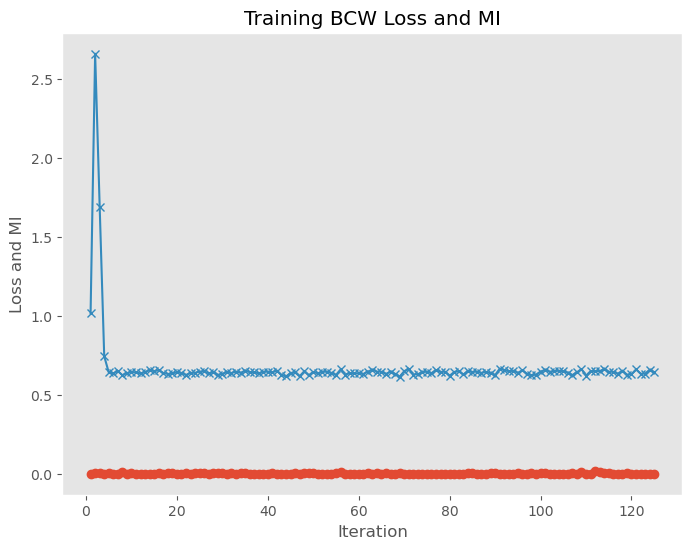

In [263]:
BCEloss_np = np.array(BCELoss_array)
MI_np = np.array(MI_array)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(MI_np)+1), MI_np, marker='o')
plt.plot(range(1, len(BCEloss_np)+1), BCEloss_np, marker='x')

plt.title('Training BCW Loss and MI')
plt.xlabel('Iteration')
plt.ylabel('Loss and MI')
plt.grid()
plt.show()

In [ ]:
# Testing loop
model.eval()
total_loss = 0.0
predictions = []
given = []
actual = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs.long(), targets.long())
        loss = criterion(outputs, targets.float())
        total_loss += loss.item()

        for i in range(len(inputs)):
            predictions.append(outputs[i].tolist())
            given.append(inputs[i].tolist())
            actual.append(targets[i].tolist())

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

# Save the model and predictions
torch.save(model.state_dict(), 'quantum_transformer_model.pth')
preds = {
    'Initial_States': given,
    'Final_State_Pred': predictions,
    'Final_States': actual
}
final_df = pd.DataFrame(preds)
final_df.head()